In [1]:
import numpy as np
from lib.envs.blackjack import BlackjackEnv
from lib import plotting
import matplotlib.pyplot as plt
from collections import defaultdict

# 1) Implement the Monte Carlo Prediction to estimate state-action values

In [2]:
env = BlackjackEnv()

In [3]:
def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    # This means that we should calculate the return ina  incremental fashion 
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final value function
    V = defaultdict(float)
    
    for i_eps in range(num_episodes):
        # Epsiodes Generation
        episode = []
        obs = env.reset()
        done = False
        while not done:
            action = policy(obs)
            next_s, r, done, _ = env.step(action)
            episode.append((obs, action, r))
            obs = next_s
        # Policy Evaluation
        g = 0
        for i,eps in enumerate(episode[::-1]):
            first_occurences = [e[0] for e in episode[:len(episode) - i - 1]]
            state = eps[0]
            reward = eps[2]
            g += (discount_factor**(len(episode) - i -1))*  reward   
            if state not in first_occurences:
                returns_sum[state] += g
                returns_count[state] += 1.0
                V[state] = returns_sum[state] / returns_count[state]
    return V

In [4]:
def sample_policy(observation):
    """
    A policy that sticks if the player score is > 20 and hits otherwise.
    """
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

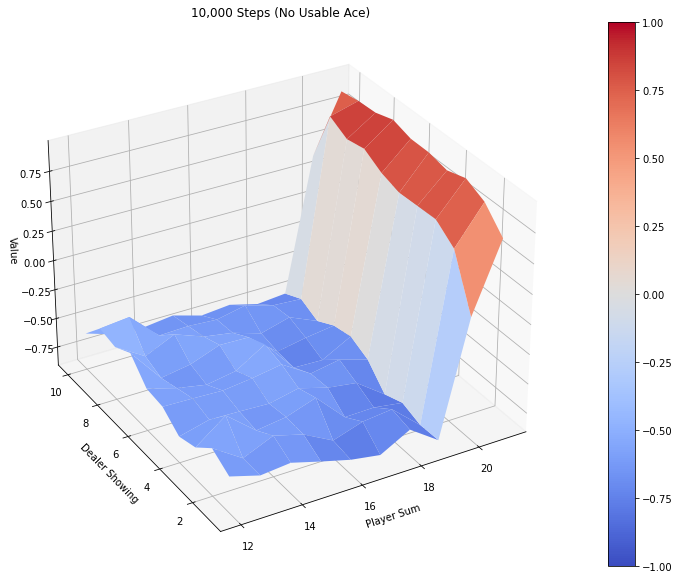

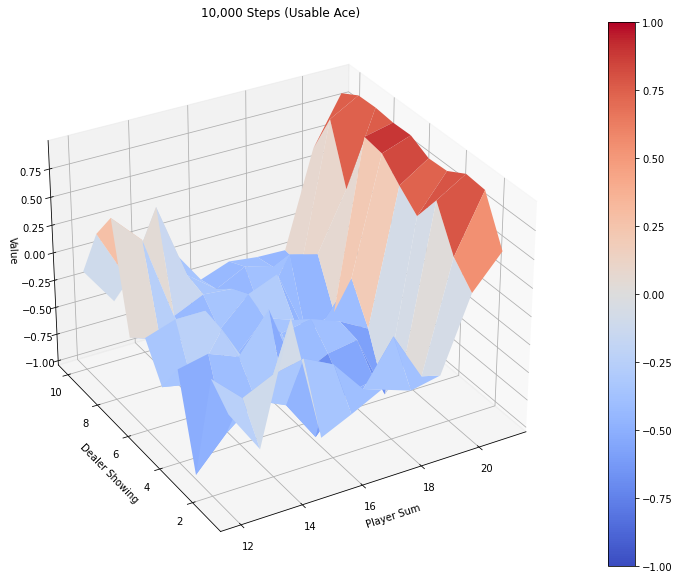

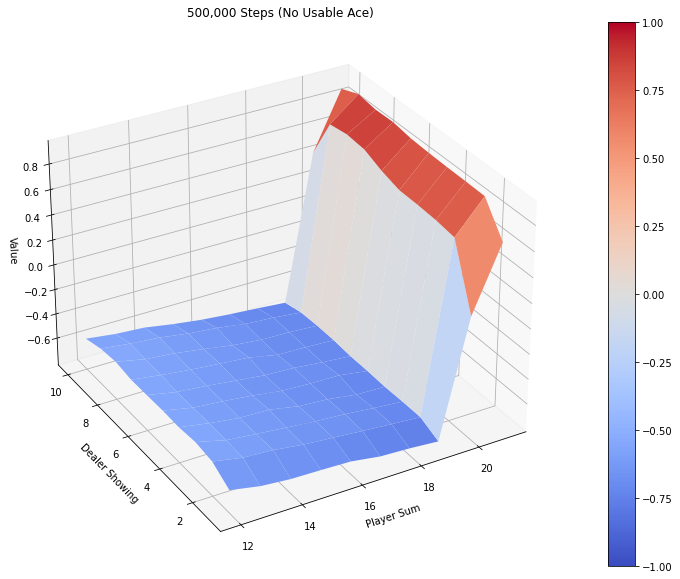

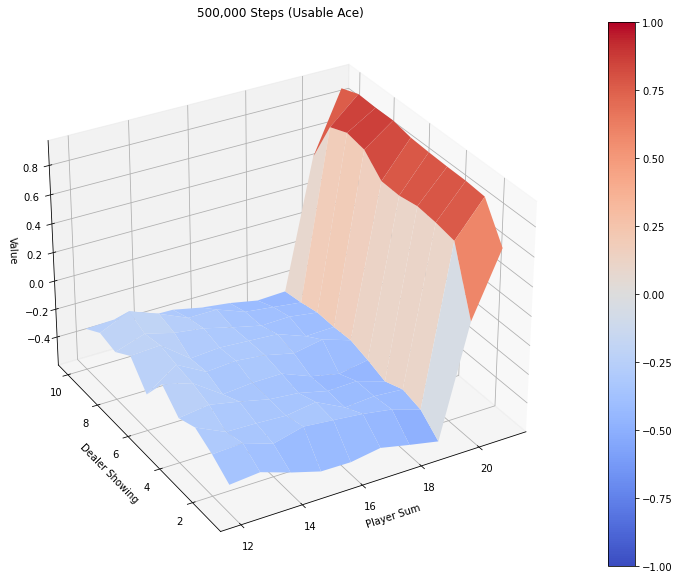

In [5]:
V_10k = mc_prediction(sample_policy, env, num_episodes=10000)
plotting.plot_value_function(V_10k, title="10,000 Steps")

V_500k = mc_prediction(sample_policy, env, num_episodes=500000)
plotting.plot_value_function(V_500k, title="500,000 Steps")

# 2) Implement the on-policy first-visit Monte Carlo Control algorithm

In [6]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        pi = np.ones(nA, dtype = float) * epsilon / nA
        best_a = np.argmax(Q[observation])
        pi[best_a] += (1 - epsilon)
        return pi
    return policy_fn

In [7]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    

    for i in range(num_episodes):
        episode = []
        obs = env.reset()
        done = False
        while not done:
            prob = policy(obs)
            action = np.random.choice(np.arange(len(prob)), p = prob)
            next_s, r, done, _ = env.step(action)
            episode.append((obs, action, r))
            obs = next_s

        g = 0
        for i,eps in enumerate(episode[::-1]):
            first_occurences = [(e[0], e[1]) for e in episode[:len(episode) - i - 1]]
            state, action, reward = eps
            g += (discount_factor**(len(episode) - i -1))*  reward   
            if (state, action) not in first_occurences:
                returns_sum[(state, action)] += g
                returns_count[(state, action)] += 1.0
                Q[state][action] = returns_sum[(state, action)] / returns_count[(state, action)]
    
    return Q, policy

In [8]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

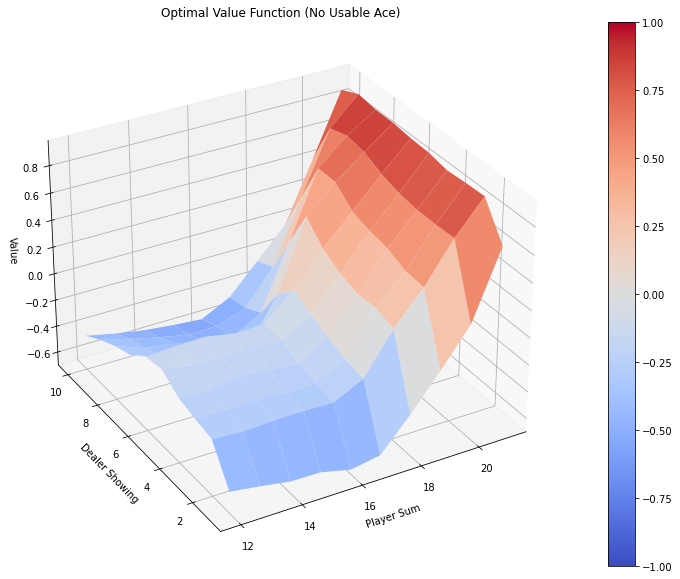

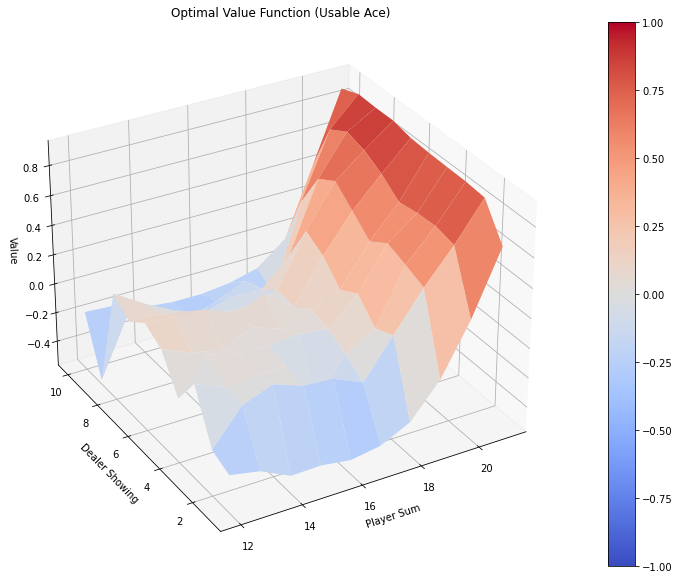

In [9]:
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")

# 3) Implement the off-policy every-visit Monte Carlo Control using Weighted Important Sampling algorithm

In [10]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [11]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(observation):
        
        best_a = np.argmax(Q[observation])
        return np.eye(*Q[observation].shape)[best_a]

    return policy_fn

In [12]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
    c = defaultdict(lambda: np.zeros(env.action_space.n))
    # Implement this!
    for i in range(num_episodes):
        episode = []
        obs = env.reset()
        done = False
        while not done:
            prob = behavior_policy(obs)
            action = np.random.choice(np.arange(len(prob)), p = prob)
            next_s, r, done, _ = env.step(action)
            episode.append((obs, action, r))
            obs = next_s
            
        g = 0
        w = 1
        for i,eps in enumerate(episode[::-1]):
            state, action, reward = eps
            g += (discount_factor**(len(episode) - i -1))*  reward  
            c[state][action] += w
            Q[state][action] += w/c[state][action] * (g - Q[state][action])
            best_action = np.argmax(target_policy(state)) 
            if action != best_action:
                break
            w *= 1/behavior_policy(state)[action]
    return Q, target_policy

In [13]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

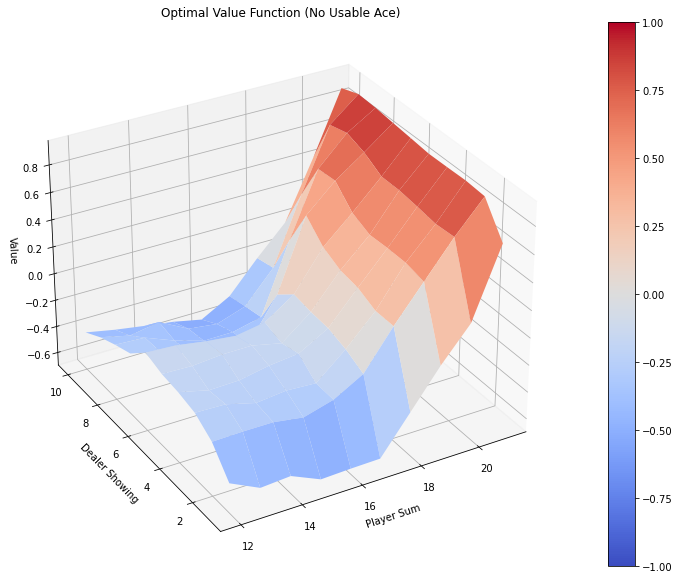

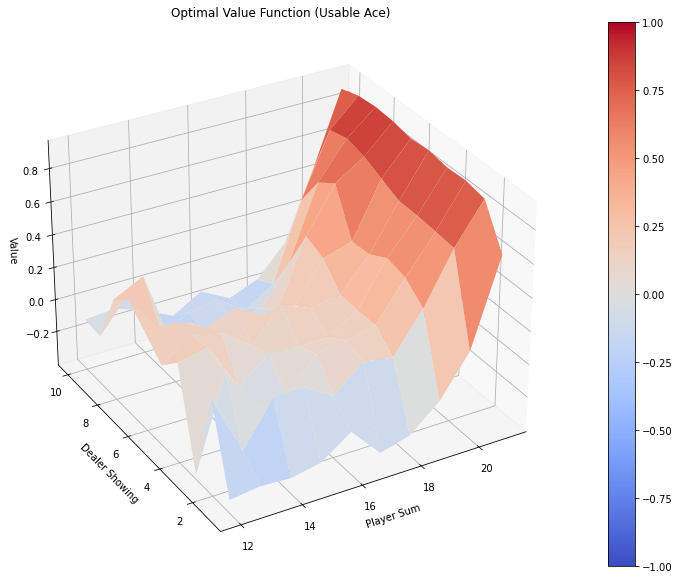

In [14]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")